In [1]:
import csv
from graph_tool import Graph
import pandas as pd
import netpixi
from netpixi.data.gt import *
import seaborn as sns
from graph_tool import centrality
from graph_tool import clustering
import matplotlib.pyplot as plt
sns.set()

### Rede
---

A rede criada é baseada em um dataset de doações de vacinas realizaas durante a pandemia do COVID-19. Desse modo, uma aresta sai de um país que doou a vacina e entra no país que recebeu a doação (rede dirigida).

In [2]:
# Dataset com as doações
donations = pd.read_csv('vacinas_certo.csv')
donations_drop = donations[['Donating Entity','Donated to','Donation Amount']]
donations_drop.head()

,Donating Entity,Donated to,Donation Amount
0,Alrosa Group,Angola,"50,000"
1,Alrosa Group,Zimbabwe,"50,000"
2,Association of Healthcare Providers,India,"100,000,000*"
3,Australia,Unknown,"38,902,000"
4,Australia,Timor-Leste,"30,000"


In [3]:
## Dataset com os PIBs de cada país
pib = pd.read_csv('pib_certo.csv')
pib.head()

,Donating Entity,2020
0,Aruba,NaN
1,Africa Eastern and Southern,9.008290e+11
2,Afghanistan,1.980707e+10
3,Africa Western and Central,7.865850e+11
4,Angola,6.230691e+10


In [4]:
# Alocando uma coluna de PIB para os países que doaram a vacina

df = pd.merge(donations_drop, pib, 
                   on='Donating Entity', 
                   how='left')
df.head()

,Donating Entity,Donated to,Donation Amount,2020
0,Alrosa Group,Angola,"50,000",NaN
1,Alrosa Group,Zimbabwe,"50,000",NaN
2,Association of Healthcare Providers,India,"100,000,000*",NaN
3,Australia,Unknown,"38,902,000",1.330900e+12
4,Australia,Timor-Leste,"30,000",1.330900e+12


In [5]:
# Alocando uma coluna de PIB para os países receptores e arrumando as colunas

df = pd.merge(df, pib, how='left', left_on = 'Donated to', right_on = 'Donating Entity')

df.drop('Donating Entity_y', axis='columns', inplace=True)

df = df.dropna(0,'any') 
df

,Donating Entity_x,Donated to,Donation Amount,2020_x,2020_y
4,Australia,Timor-Leste,"30,000",1.330900e+12,1.821000e+09
7,Australia,Fiji,"1,000,000",1.330900e+12,4.376015e+09
8,Australia,Solomon Islands,"60,000",1.330900e+12,1.551246e+09
9,Australia,Papua New Guinea,"8,000",1.330900e+12,2.359152e+10
13,Azerbaijan,Tajikistan,"40,000",4.260718e+10,8.194150e+09
...,...,...,...,...,...
373,United States,Ukraine,"428,571",2.093660e+13,1.555820e+11
375,United States,West Bank and Gaza,"428,571",2.093660e+13,1.556130e+10
380,United States,Canada,"1,500,000",2.093660e+13,1.644040e+12
381,United States,Mexico,"2,500,000",2.093660e+13,1.076160e+12


In [6]:
df = df.rename(columns = {'Donating Entity_x': 'Donating Entity', '2020_x': 'PIB_doador', '2020_y': 'PIB_receptor'}, 
                     inplace = False)

In [7]:
# Transformando a coluna de doações em float
df['amount'] = df['Donation Amount'].str.replace(',', '').astype(float)
df.drop('Donation Amount', axis='columns', inplace=True)
df = df.rename(columns = {'amount': 'Donation_Amount'}, inplace = False)
df

,Donating Entity,Donated to,PIB_doador,PIB_receptor,Donation_Amount
4,Australia,Timor-Leste,1.330900e+12,1.821000e+09,30000.0
7,Australia,Fiji,1.330900e+12,4.376015e+09,1000000.0
8,Australia,Solomon Islands,1.330900e+12,1.551246e+09,60000.0
9,Australia,Papua New Guinea,1.330900e+12,2.359152e+10,8000.0
13,Azerbaijan,Tajikistan,4.260718e+10,8.194150e+09,40000.0
...,...,...,...,...,...
373,United States,Ukraine,2.093660e+13,1.555820e+11,428571.0
375,United States,West Bank and Gaza,2.093660e+13,1.556130e+10,428571.0
380,United States,Canada,2.093660e+13,1.644040e+12,1500000.0
381,United States,Mexico,2.093660e+13,1.076160e+12,2500000.0


In [8]:
g = Graph(directed=True)

In [9]:
# Criando uma propriedade para os vértices de Países
g.vp['Nome País'] = g.new_vp('object')

lista_paises = []

for i in df['Donating Entity']:
    if i not in lista_paises:
        lista_paises.append(i)
        
for i in df['Donated to']:
    if i not in lista_paises:
        lista_paises.append(i)
    
for i in range(len(lista_paises)):
    g.add_vertex()
    g.vp['Nome País'][i] = lista_paises[i]

In [10]:
for e in g.vertices():
    print(g.vp['Nome País'][e])

print(len(lista_paises))

Australia
Azerbaijan
Barbados
Chile
China
France
Germany
India
Ireland
Israel
Japan
Lithuania
Mexico
Morocco
New Zealand
Poland
Portugal
Romania
Serbia
South Africa
Turkey
United States
Timor-Leste
Fiji
Solomon Islands
Papua New Guinea
Tajikistan
Uzbekistan
Guyana
Ecuador
Malaysia
Thailand
Vietnam
Cambodia
Kiribati
Philippines
Myanmar
Sri Lanka
Pakistan
Nepal
El Salvador
Namibia
North Macedonia
Afghanistan
Chad
Congo, Rep.
Djibouti
Bolivia
Equatorial Guinea
Georgia
Guinea
Iraq
Sierra Leone
Gabon
Togo
Algeria
Angola
Belarus
Dominican Republic
Ethiopia
Lebanon
Maldives
Mauritania
Mongolia
Montenegro
Niger
Sudan
Tunisia
Zimbabwe
Bangladesh
Benin
Botswana
Cameroon
Mauritius
Somalia
Ukraine
Moldova
Cote d'Ivoire
Bhutan
Jamaica
Paraguay
Albania
Belize
Dominica
Eswatini
Ghana
Guatemala
Kenya
Malawi
Mozambique
Nicaragua
Nigeria
Rwanda
Senegal
Seychelles
St. Lucia
Suriname
Uganda
Honduras
West Bank and Gaza
Indonesia
Cyprus
Libya
Lesotho
Liberia
Madagascar
Panama
Peru
Colombia
Costa Rica
Argent

In [14]:
# Criando as arestas e uma propriedade de aresta indicando quantas vacinas foram doadas

from graph_tool import util

g.ep['Número de doações'] = g.new_ep('object')

for pais_doador, pais_receptor, index in zip(df['Donating Entity'], df['Donated to'], df.index):
    str_index_doador = util.find_vertex(g,g.vp['Nome País'],pais_doador) 
    index_doador = int(str(str_index_doador).split(" ")[4].replace("'","")) #pega o índice do doador
    
    str_index_receptor = util.find_vertex(g,g.vp['Nome País'],pais_receptor) 
    index_receptor = int(str(str_index_receptor).split(" ")[4].replace("'","")) #pega o índice do receptor
    
    aresta_existe = 0
    for e in g.edges():
        if g.ep['Número de doações'][e] == None:
            g.ep['Número de doações'][e] = 0

        # Se a aresta já existir, incrementa o número de vacinas doadas
        if e.source() == index_doador and e.target() == index_receptor:
            g.ep['Número de doações'][e] += int(df['Donation_Amount'][index])
            aresta_existe = 1

    # Se a aresta não existe, cria uma nova
    if aresta_existe == 0:
        g.add_edge(index_doador, index_receptor)
        
        e = g.edge(index_doador, index_receptor)
        g.ep['Número de doações'][e] = df['Donation_Amount'][index]


Vamos verificar se funcionou:

In [13]:
for e in g.edges():
    print(g.ep['Número de doações'][e])


30000
1000000.0
60000.0
8000.0
40000.0
50000.0
3000.0
20000.0
1500000.0
2500000.0
3500000.0
6903000.0
100000.0
90000.0
2000000.0
3000000.0
2700000.0
5500000.0
3400000.0
300000.0
1650000.0
100000.0
1400000.0
1100000.0
200000.0
100000.0
300000.0
300000.0
100000.0
200000.0
400000.0
40000.0
350000.0
200000.0
100000.0
200000.0
200000.0
200000.0
150000.0
30000.0
100000.0
50000.0
300000.0
50000.0
418000.0
50000.0
300000.0
30000.0
400000.0
250000.0
100000.0
800000.0
600000.0
100000.0
200000.0
200000.0
20000.0
100000.0
200000.0
218400.0
25000.0
25000.0
25000.0
25000.0
200000.0
50000.0
3300000.0
550000.0
200000.0
1100000.0
200000.0
500000.0
50000.0
100000.0
25000.0
30000.0
70000.0
30000.0
20000.0
100000.0
50000.0
200000.0
80000.0
100000.0
50000.0
100000.0
150000.0
100000.0
1700000.0
30000.0
200000.0
25000.0
100000.0
50000.0
25000.0
50000.0
500000.0
25000.0
50000.0
100000.0
35000.0
335500.0
5000.0
5000.0
3000000.0
1000000.0
1000000.0
1000000.0
1000000.0
1050000.0
15000.0
11000.0
100000.0
100800.0

In [15]:
save_gt(g, 'doacao_vacinas.net.gz')
r = netpixi.render('doacao_vacinas.net.gz');

In [16]:
r.vertex_set_key('Nome País')

### Hipótese 
---

1) Países com maior economia doam mais vacinas

Mecanismo: Países mais ricos produziram e vacinaram pessoas mais rápido para poder voltar sua economia por possuirem mais recursos e maior organização para a vacinação de sua população. Com isso, sobraram mais vacinas do que esperado e portanto, doaram suas vacinas pois parte de sua economia depende da economia do resto do mundo para exportar seus produtos.

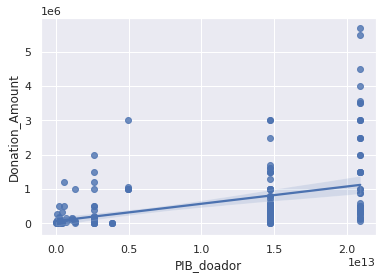

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.regplot(x=df['PIB_doador'], y=df['Donation_Amount'])
plt.show()


Após plotar o gráfico de correlação entre as duas variáveis de interesse, foi notado que os valores ficaram "achatados", sendo necessário aplicar o log:

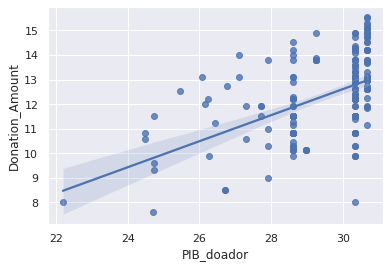

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

sns.regplot(x=np.log(df['PIB_doador']), y=np.log(df['Donation_Amount']))
plt.show()


Parece que a relação entre PIB e doações realmente existe. Para verificar:

In [20]:
import numpy as np
import statsmodels.formula.api as smf

model = smf.ols(data=df, formula='np.log(Donation_Amount) ~ PIB_doador')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     np.log(Donation_Amount)   R-squared:                       0.277
Model:                                 OLS   Adj. R-squared:                  0.274
Method:                      Least Squares   F-statistic:                     82.35
Date:                     Tue, 02 Nov 2021   Prob (F-statistic):           7.40e-17
Time:                             22:51:34   Log-Likelihood:                -371.22
No. Observations:                      217   AIC:                             746.4
Df Residuals:                          215   BIC:                             753.2
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1155      0.163     68.341      0.000      10.795      11.436
PIB_doador  1.084e-13   1.19e-14      9.075      0.000    8.49e-14    1.32e-13
==============================================================================
Omnibus:                        0.977   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.709
Skew:                          -0.121   Prob(JB):                        0.702
Kurtosis:                       3.139   Cond. No.                     2.43e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

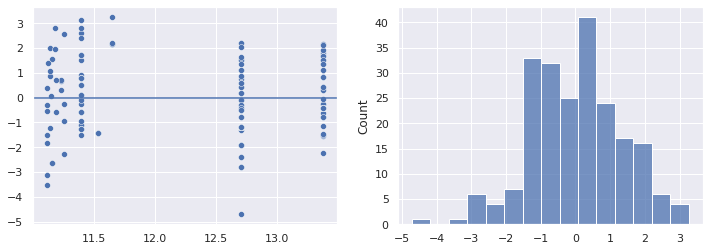

In [21]:
from matplotlib import rcParams

def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

linear_resplot(result)

A partir do modelo é possível rejeitar a hipótese nula dado que o P-Valor obtido é menor que 0.1 e, portanto, pode-se afirmar que quanto mais rico um país é, mais doações de vacinas ele realizou. Porém, o R-squared obtido foi de apenas 0.277, indicando que o poder explicativo do modelo é ruim.

---